## Human Limb Parameter Estimation
Notebook to estimate the human limb's kinematic parameters using the algorithm proposed in the paper.


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import sys
import json
import os

sys.path.append("scripts")

In [4]:
import itertools
import functools
import pandas as pd
import progressbar as pb

In [5]:
from areboest import run_calibration, normalize, generate_calib_data
from areboest import estimate_limb_param, gen_polysine
from areboest import get_random_humanparams, get_subject_calib_angles
from areboest import get_all_params

### AREBO Estimation

In [6]:
# AREBO parameters
a = 27.0
b = 20.0
c = 10.0

arebo_dh = [{'a': 0, 'al': +np.pi/2, 'd': 0, 't': 0},
            {'a': a, 'al': 0,        'd': 0, 't': 0},
            {'a': b, 'al': 0,        'd': 0, 't': 0},
            {'a': 0, 'al': -np.pi/2, 'd': 0, 't': -np.pi/2},
            {'a': 0, 'al': +np.pi/2, 'd': c, 't': +np.pi/2},
            {'a': 0, 'al': 0,        'd': 0, 't': +np.pi/2}]

## Static Shoulder Position
1. Generate a random set of 100 parameters for the human limb.
2. Implement a set of 100 random calibration procedure for each parameter set for three different noise levels.
3. Estimate the difference between the true parameter and the estimate parameter. 

In [7]:
# Number of human parameter values
Np = 20

# Number of calibration procedures
Nc = 50

# Number of different calibration durations
Ncd = 3

# Number of noise levels
Nn = 3

# Subject joint angle ranges for calibration
pvrange = [0, 90]
phrange = [-30, 30]
prrange = [0]

# Shoulder position ranges
shpos_range = np.array([[-10, 10],
                        [-10, 10],
                        [10, 30]])

# Upper-arm length ranges
l_range = np.array([15, 20])

# Different calibration durations
calib_dur = np.array([1.0, 2.0, 5.0])

# Noise levels
angnoise = np.array([0.0, 1.0, 5.0]) * np.pi / 180.0

# Time
dt = 0.01
T = calib_dur[-1]
t = np.arange(0, T, dt)
NT = len(t)

# Human Arm parameters
human_dh = [{'a': 0, 'al': +np.pi/2, 'd': 0,  't': 0},
            {'a': 0, 'al': -np.pi/2, 'd': 0,  't': -np.pi/2},
            {'a': 0, 'al': 0,        'd': 15, 't': -np.pi}]

In [8]:
# Generate random human limb parameter sets
sh_pos, l = get_random_humanparams(shpos_range, l_range, Np)

# Generate random calibration movements
ang_calib = [get_subject_calib_angles(t, pvrange, phrange)
             for _n in range(Nc)]

In [9]:
# define progress bar
widgets = ['[', pb.Timer(), '] ', pb.Bar(), ' (', pb.ETA(), ')']
bar = pb.ProgressBar(widgets=widgets, maxval=Np * Nc * Nn).start()

cnt = -1
for hp, angc, angn, _N in get_all_params(np.vstack((sh_pos, l)).T,
                                         ang_calib, angnoise):
    cnt += 1
    # Generate calibration data
    _shpos = np.tile(hp[1][:3], (NT, 1)).T
    human_dh[2]['d'] = hp[1][3]
    
    calibdata = generate_calib_data(tv=angc[1][0], th=angc[1][1], tr=angc[1][2],
                                    sh_pos=_shpos, uh=hp[1][3],
                                    arebo_dh=arebo_dh, human_dh=human_dh,
                                    noise=angn[1])
    
    # Save calibration data.
    _fname = f"est_data/calibdata_{hp[0]}_{angc[0]}_{angn[0]}.csv"
    calibdata.to_csv(path_or_buf=_fname, index=False)

    # Update
    bar.update(cnt)

scripts\arebo.py:84: RuntimeWarning: invalid value encountered in arccos:31:41)
  ta3 = np.arccos(_n / _d)
scripts\arebo.py:90: RuntimeWarning: invalid value encountered in arccos
  beta = np.arccos(_n / _d)


## Estimating human limb parameters

In [11]:
# Read each calibration data file and estimate the human limb 
# parameters 
# define progress bar
widgets = ['[', pb.Timer(), '] ', pb.Bar(), ' (', pb.ETA(), ')']
bar = pb.ProgressBar(widgets=widgets, maxval=Np * Nc * Nn).start()

# Data frame with the estimated parameters
paramestdf = pd.DataFrame(columns=('shx', 'shy', 'shz', 'l', 'calibn', 'dur', 'noise',
                                   'shxest', 'shyest', 'shzest', 'lest'))

cnt = -1
for hp, angc, angn, _N in get_all_params(np.vstack((sh_pos, l)).T,
                                         ang_calib, angnoise):
    cnt += 1
    # Load calibration data.
    _fname = f"est_data/calibdata_{hp[0]}_{angc[0]}_{angn[0]}.csv"
    calibdata = pd.read_csv(_fname)

    for cald in calib_dur:
        N = int(cald / dt)
        pest = estimate_limb_param(calibdata, N, N)
        # Update estimated parameters
        _dfrow = {"shx": [calibdata.iloc[0]['shx']],
                  "shy": [calibdata.iloc[0]['shy']],
                  "shz": [calibdata.iloc[0]['shz']],
                  "l": [calibdata.iloc[0]['l']],
                  "calibn": [angc[0]],
                  'dur': [cald],
                  'noise': [angn[1]],
                  "shxest": [pest[1, 0]],
                  "shyest": [pest[2, 0]],
                  "shzest": [pest[3, 0]],
                  "lest": [pest[0, 0]]
                  }
        paramestdf = paramestdf.append(pd.DataFrame.from_dict(_dfrow),
                                           ignore_index=True)

    # Update
    bar.update(cnt)

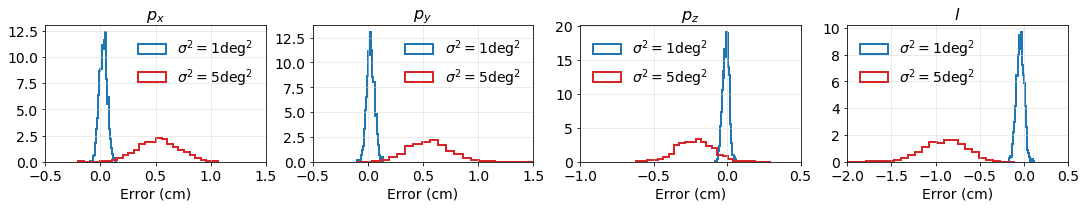

In [12]:
# Analysis for 0ifferent noise and durations
_colors = ["tab:blue", "tab:red"]
# _limsx = [[-0.5, 2.5], [-0.5, 1.5], [-0.5, 1.5]]
dlim = 0.5
_limsx = [-0.5, 1.5]  # [-1.0, 3.0]
_limsy = [-0.5, 1.5]  # [-1.0, 3.0]
_limsz = [-1.0, 0.5]  # [-2.0, 1.0]
_limsl = [-2.0, 0.5]  # [-4.0, 1.0]
_labels = ["$\sigma^2 = 1\deg^2$", "$\sigma^2 = 5\deg^2$"]
fig = figure(figsize=(15, 3))
# Calibration duration
for ndur in range(2, 3):
    durinx = paramestdf["dur"] == calib_dur[ndur]
    ax = fig.add_subplot(1, 4, 4 * (ndur - 2) + 1)
    ax.grid(color='0.85', linestyle='-', linewidth=0.5)
    for i, _noise in enumerate(angnoise[1:]):
        inx = durinx & (paramestdf["noise"] == _noise)
        _data = np.array(paramestdf[inx]['shxest'] - paramestdf[inx]['shx'])
        ax.hist(_data, bins=25, density=True, histtype='step', lw=2,
                color=_colors[i], label=_labels[i])
    ax.set_xlim(_limsx[0], _limsx[1])
    xticks(np.arange(_limsx[0], _limsx[1] + dlim, dlim), fontsize=14)
    yticks(fontsize=14)
    ax.set_xlabel("Error (cm)", fontsize=14)
    ax.set_title(f"$p_x$", fontsize=16)
    legend(loc=1, fontsize=14, frameon=False, ncol=1)

    ax = fig.add_subplot(1, 4, 4 * (ndur - 2) + 2)
    ax.grid(color='0.85', linestyle='-', linewidth=0.5)
    for i, _noise in enumerate(angnoise[1:]):
        inx = durinx & (paramestdf["noise"] == _noise)
        _data = np.array(paramestdf[inx]['shyest'] - paramestdf[inx]['shy'])
        ax.hist(_data, bins=25, density=True, histtype='step', lw=2,
                color=_colors[i], label=_labels[i])
    ax.set_xlim(_limsy[0], _limsy[1])
    xticks(np.arange(_limsy[0], _limsy[1] + dlim, dlim), fontsize=14)
    yticks(fontsize=14)
    ax.set_xlabel("Error (cm)", fontsize=14)
    ax.set_title(f"$p_y$", fontsize=16)
    legend(loc=1, fontsize=14, frameon=False, ncol=1)
        
    ax = fig.add_subplot(1, 4, 4 * (ndur - 2) + 3)
    ax.grid(color='0.85', linestyle='-', linewidth=0.5)
    for i, _noise in enumerate(angnoise[1:]):
        inx = durinx & (paramestdf["noise"] == _noise)
        _data = np.array(paramestdf[inx]['shzest'] - paramestdf[inx]['shz'])
        ax.hist(_data, bins=25, density=True, histtype='step', lw=2,
                color=_colors[i], label=_labels[i])
    ax.set_xlim(_limsz[0], _limsz[1])
    xticks(np.arange(_limsz[0], _limsz[1] + dlim, dlim), fontsize=14)
    yticks(fontsize=14) 
    ax.set_xlabel("Error (cm)", fontsize=14)
    ax.set_title(f"$p_z$", fontsize=16)
    legend(loc=2, fontsize=14, frameon=False, ncol=1)

    ax = fig.add_subplot(1, 4, 4 * (ndur - 2) + 4)
    ax.grid(color='0.85', linestyle='-', linewidth=0.5)
    for i, _noise in enumerate(angnoise[1:]):
        inx = durinx & (paramestdf["noise"] == _noise)
        _data = np.array(paramestdf[inx]['lest'] - paramestdf[inx]['l'])
        ax.hist(_data, bins=25, density=True, histtype='step', lw=2,
                color=_colors[i], label=_labels[i])
    ax.set_xlim(_limsl[0], _limsl[1])
    xticks(np.arange(_limsl[0], _limsl[1] + dlim, dlim), fontsize=14)
    yticks(fontsize=14)
    ax.set_xlabel("Error (cm)", fontsize=14)
    ax.set_title(f"$l$", fontsize=16)
    legend(loc=2, fontsize=14, frameon=False, ncol=1)

plt.tight_layout()

fig.savefig(f"est_data/img/est_static_param.svg", format="svg", dpi=300);
fig.savefig(f"est_data/img/est_static_param.png", format="png", dpi=300);

In [14]:
nnoise, ndur = 1, 2
inx = ((paramestdf['dur'] == calib_dur[ndur]) &
       (paramestdf['noise'] == angnoise[nnoise]))
# Parameter estimates
pest = np.array(paramestdf[inx][['lest', 'shxest', 'shyest', 'shzest']])
pact = np.array(paramestdf[inx][['l', 'shx', 'shy', 'shz']])
perr = pest - pact

# Mean error
errmean = np.mean(perr, axis=0)
print("Mean error (cm): ", errmean)

# Error covariance
Cerr = ((perr - errmean).T @ (perr - errmean)) / len(pest)
np.round(Cerr, decimals=6)

Mean error (cm):  [-0.04131048  0.02548631  0.0255281  -0.00811453]


array([[ 1.805e-03, -9.580e-04, -1.025e-03, -5.800e-05],
       [-9.580e-04,  1.162e-03,  6.390e-04, -5.700e-05],
       [-1.025e-03,  6.390e-04,  1.212e-03, -4.700e-05],
       [-5.800e-05, -5.700e-05, -4.700e-05,  4.580e-04]])

In [15]:
nnoise, ndur = 2, 2
inx = ((paramestdf['dur'] == calib_dur[ndur]) &
       (paramestdf['noise'] == angnoise[nnoise]))
# Parameter estimates
pest = np.array(paramestdf[inx][['lest', 'shxest', 'shyest', 'shzest']])
pact = np.array(paramestdf[inx][['l', 'shx', 'shy', 'shz']])
perr = pest - pact

# Mean error
errmean = np.mean(perr, axis=0)
print("Mean error (cm): ", errmean)

# Error covariance
Cerr = ((perr - errmean).T @ (perr - errmean)) / len(pest)
np.round(Cerr, decimals=6)

Mean error (cm):  [-0.89956734  0.52892774  0.56272894 -0.2175365 ]


array([[ 0.059589, -0.028721, -0.035078, -0.003623],
       [-0.028721,  0.034449,  0.017559,  0.000279],
       [-0.035078,  0.017559,  0.041191,  0.001325],
       [-0.003623,  0.000279,  0.001325,  0.015919]])